In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from astropy import units as u
import scipy
from mesa_reader import MesaData
import pandas as pd

In [2]:
Ms = 1.989e33
Rs = 6.96e10
Ls = 3.826e33
G = 6.67e-8
c = 3e10
sigma_sb = 5.67e-5
Na = 6.02e23
k = 1.38e-16
a = 7.56e-15

In [3]:
M = 1.4 * Ms
X = 0.7
Y = 0.28
Z = 0.02

mu = 4 / (3 + 5*X)

In [4]:
with open('LosAlamosY=0.28.txt', 'r') as f:
    lines = f.readlines()

In [37]:
def opacity(lines, rt, Tc):
    'interpolates opacity from Los Alamos opacity table given table, radius and temperature'
    if rt.any() <= 0 or Tc.any() <= 0:
        return 1
    logR = np.array([float(x) for x in lines[0].split()[2:]])
    data = np.loadtxt(lines[2:])  
    logT = data[:, 0]
    kappa = data[:, 1:]
    interpolator = RegularGridInterpolator((logT, logR), kappa, bounds_error=False, fill_value=None)
    k = interpolator((np.log10(Tc), np.log10(rt)))
    return 10**k

In [6]:
def energy_generation_pp(rho, T, X):
    'calculates energy generation from the PP chain given density, temperature, and hydrogen fraction'
    #KWW 18.51 equ 18.63
    psi = 1 #?
    T9 = T/1e9 
    T7 = T/1e7
    
    #f_11 equation from google
    t = 5.92e-3*1*((rho/(T7**3))**(1/2))
    f_11 =  np.exp(t)
    
    #g_11
    g_11 = 1 + (3.82* T9) + (1.51* T9**2) + (0.144* T9**3) - (0.0114* T9**4)
    
    #epsilon
    ep_pp = 2.57e4 * psi * f_11 * g_11 * rho * X**2 * T9**(-2/3) * np.exp(-3.381/(T9**(1/3)))
    return ep_pp

In [7]:
def energy_generation_CNO(rho, T, X, Z):
    'calculates energy generation from the CNO cycle given density, temperature, hydrogen fraction, and metal fraction'
    #KWW 18.51 equ 18.65
    T9 = T/1e9
    
    X_cno = Z #assuming most metals are carbon, oxygen, and nitrogen
    
    g_141 = 1 - (2.00*T9) + (3.41*T9**2) - (2.43*T9**3)
    
    ep_CNO = 8.24e25*g_141*X_cno*X*rho*T9**(-2/3)*np.exp((-15.231*T9**(-1/3))-(T9/0.8)**2)
    return ep_CNO

In [35]:
def density(X, Y, T, P):
    'calculates density given hydrogen fraction, helium fraction, temperature, and pressure'
    a = 7.56e-15
    k = 1.38e-16
    m_H = 1.67e-24

    mu = 1 / (2*X + 0.75*Y + 0.5*(1 - X - Y))

    Pr = (1/3) * a * T**4
    Pg = P - Pr
    if Pg.any() <= 0:
        return np.nan

    rho = Pg * mu * m_H / (k * T)


    return rho

In [9]:
def del_rad(Mr, L, P, T, X,Y,op_table):
    'calculates del due to radiation given mass, luminosity, pressure, temperature, hydrogen fraction, helium fraction, and opacity table'
    rho = density(X, Y, Tc, Pc)
    rt = rho / Tc**3
    kappa = opacity(op_table, rt, Tc)
    del_rad = 3 / (16 * np.pi * a * c * G) * (P * kappa * L) / (T**4 * Mr)
    return del_rad

In [10]:
def del_ad(P, T):
    'calculates del due to adiabatic given pressure and temperature'
    Pr = (1/3) * a * T**4
    b = 1 - (Pr / P)
    del_ad = 2 * (4-3*b)/(32-24*b-3*b**2)
    return del_ad

In [11]:
def del_nabla(M, L, P, T, X,Y,op_table):
    'calculates del nabla given mass, luminosity, pressure, temperature, hydrogen fraction, helium fraction, and opacity table'
    rho = density(X, Y, Tc, Pc)
    rt = rho / Tc**3
    kappa = opacity(op_table, rt, Tc)
    nabla_del = np.nanmin([del_rad(M, P, L, T, X, Y, lines), del_ad(P, T)], axis=0)
    return nabla_del

In [12]:
def load1(Tc, Pc, X, Z, l, op_table, m, m0=1e-5):
    'give the values of the four dependent variables l, P , r, and T at a mass point m very slightly away from the center of the star for use as initial values of outward integrations. '
    Mcp = m
    a = 7.56e-15
    rho = density(X, Y, Tc, Pc)
    if not np.isfinite(rho) or rho <= 0:
        print(f"Invalid rho: {rho}")
        return np.array([np.nan]*4)

    e_pp = energy_generation_pp(rho, Tc, X)
    e_cno = energy_generation_CNO(rho, Tc, X, Z)
    l = (e_pp + e_cno) * Mcp

    try:
        P = Pc - (3*G/(8*np.pi)) * ((4*np.pi*rho/3)**(4/3)) * (Mcp**(2/3))
        r = (3*Mcp/(4*np.pi*rho))**(1/3)
    except Exception as e:
        print(f"Failed to compute P or r: {e}")
        return np.array([np.nan]*4)

    rt = rho / Tc**3
    kappa = opacity(op_table, rt, Tc)
    if not np.isfinite(kappa):
        print(f"Invalid kappa: {kappa}, rt={rt}, Tc={Tc}")
        return np.array([np.nan]*4)

    T4 = Tc**4 - 1/(2*a*c) * (3/(4*np.pi))**(2/3) * kappa * (e_pp + e_cno) * rho**(4/3) * Mcp**(2/3)
    if T4 <= 0 or not np.isfinite(T4):
        print(f"Invalid T⁴ value: {T4}")
        return np.array([np.nan]*4)

    T = T4**(1/4)
    return np.array([l, P, r, T])

In [13]:
def load2(m, L_star, R_star, Pc, Tc, X, Y, Z, op_table):
    'give the same four dependent variables at the surface for use as initial values of inward integrations. '
    l = L_star
    r = R_star
    
    T_eff = (L_star / (4*np.pi*R_star**2*sigma_sb))**(1/4)
    
    rho = density(X, Y, T_eff, Pc)
    rt = rho / T_eff**3
    kappa = opacity(op_table, rt, T_eff)

    #print(kappa)
    P = (2*G*m/(3*r**2*kappa))
    #print(P)
    return np.array([l, P, r, T_eff])

In [14]:
def derivs(m, y, X, Y, Z, op_table):
    'takes the independent variable m and the four dependent variables l, P , r, and T and return the derivatives dl/dm, dP/dm, dr/dm, dT /dm'
    l, P, r, T = y
    rho = density(X, Y, T, P)
    
    # Check for non-physical values to prevent crashing
    if rho <= 0 or T <= 0:
        return [0, 0, 0, 0]

    e_pp = energy_generation_pp(rho, T, X)
    e_cno = energy_generation_CNO(rho, T, X, Z)
    kappa = opacity(op_table, np.log10(rho), np.log10(T))
    
    a = 7.56e-15
    c = 2.998e10
    G = 6.67259e-8
    
    del_rad = 3 * P * l * kappa / (16 * np.pi * a * c * G * m * T**4)
    del_ad = 0.4  # or 5/3 - 1 depending on γ
    
    del_ = min(del_rad, del_ad)

    dl_dm = e_pp + e_cno
    dP_dm = -G * m / (4 * np.pi * r**4)
    dr_dm = 1 / (4 * np.pi * r**2 * rho)
    dT_dm = -G * m * T / (4 * np.pi * r**4 * P) * del_
    
    return [dl_dm, dP_dm, dr_dm, dT_dm]

In [15]:
def shootf(M, L_star, R_star, Pc, Tc, X, Y, Z, op_table, detailed=False, M_meeting_point = 0.5,M_start=1e-5):
    'shooting to a fitting point using load1 and load2'
    steps = 10000
    m0 = M_start * M
    M_center = np.linspace(m0, M_meeting_point * M, steps)
    sol_center = scipy.integrate.solve_ivp(
    derivs,
    t_span=(M_center[0], M_center[-1]),
    y0=load1(Tc, Pc, X, Y, Z, op_table, m0),
    args=(X, Y, Z, op_table),
    method='RK45',
    t_eval=M_center
)
    M_surface = np.linspace(1, M_meeting_point, steps) * M
    sol_surface = scipy.integrate.solve_ivp(
    derivs,
    t_span=(M_surface[0], M_surface[-1]),
    y0=load2(M, L_star, R_star, Pc, Tc, X, Y, Z, op_table),
    args=(X, Y, Z, op_table),
    method='RK45',
    t_eval=M_surface
)
    return sol_center, sol_surface

In [16]:
#initial conditions based off MESA
R = 7e10
L = 1.2e34
Pc = 2e17
Tc = 1.75e7

initial_guess = np.array([Pc, R, L, Tc])
initial_guess

array([2.00e+17, 7.00e+10, 1.20e+34, 1.75e+07])

In [17]:
sol1, sol2 = shootf(M, L, R, Pc, Tc, X, Y, Z, lines, detailed=True, M_start=1e-5)

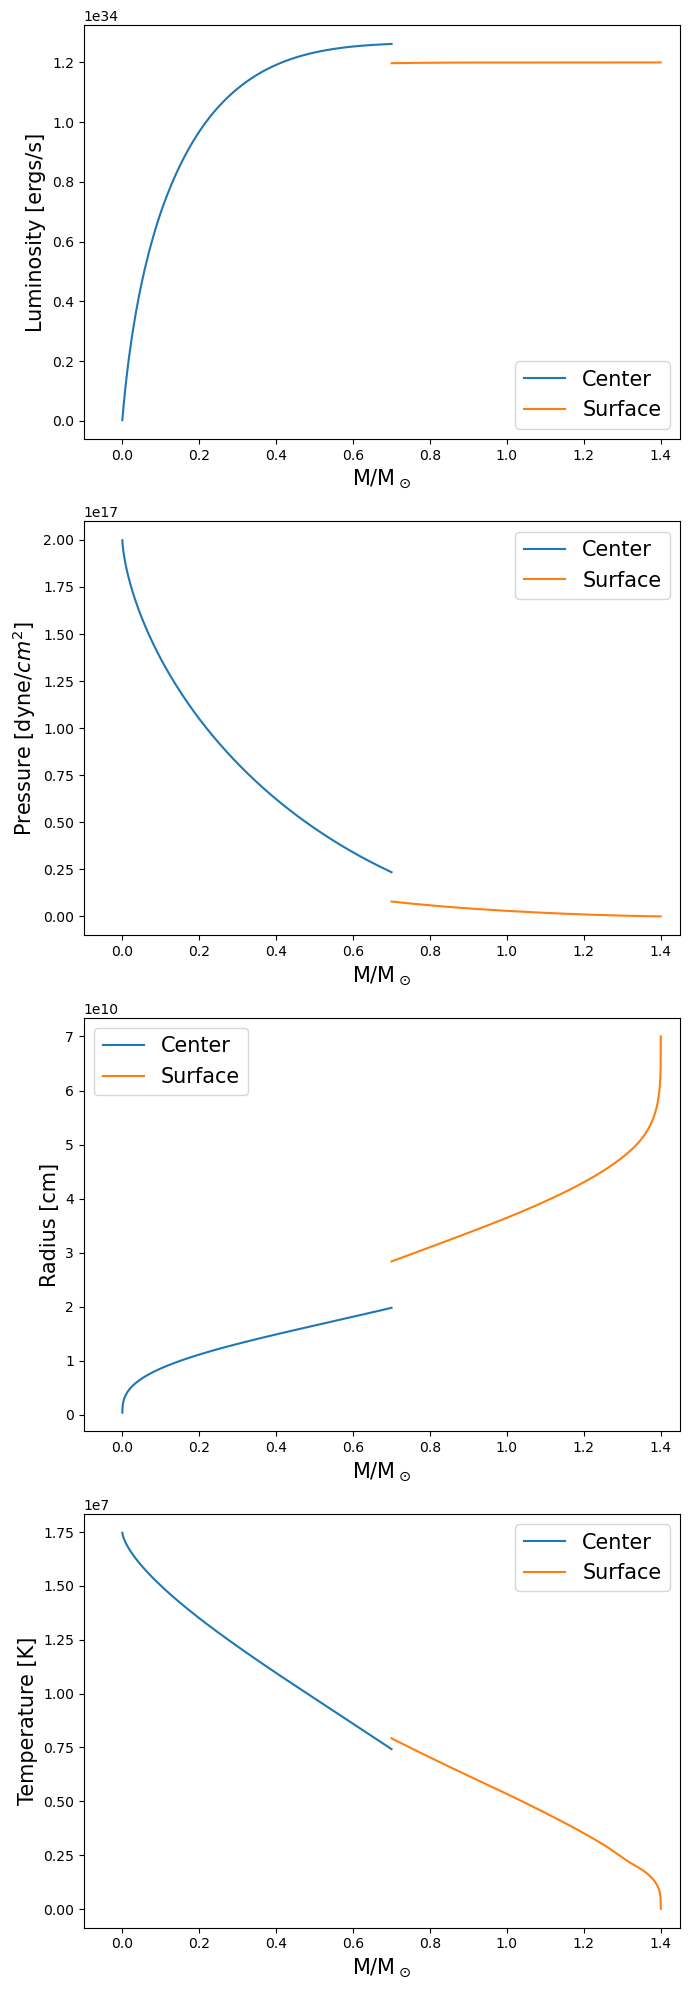

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))

axs[0].plot(sol1.t/Ms, sol1.y[0, :])
axs[0].plot(sol2.t/Ms, sol2.y[0, :])
axs[0].set_xlabel('M/M$_\odot$', fontsize=15)
axs[0].set_ylabel('Luminosity [ergs/s]', fontsize=15)
axs[0].set_xlim(-0.1, 1.45)
axs[0].legend(['Center', 'Surface'], fontsize=15)

axs[1].plot(sol1.t/Ms, sol1.y[1, :])
axs[1].plot(sol2.t/Ms, sol2.y[1, :])
axs[1].set_xlabel('M/M$_\odot$', fontsize=15)
axs[1].set_ylabel(r'Pressure [dyne/$cm^{2}$]', fontsize=15)
axs[1].set_xlim(-0.1, 1.45)
axs[1].legend(['Center', 'Surface'], fontsize=15)

axs[2].plot(sol1.t/Ms, sol1.y[2, :])
axs[2].plot(sol2.t/Ms, sol2.y[2, :])
axs[2].set_xlabel('M/M$_\odot$', fontsize=15)
axs[2].set_ylabel('Radius [cm]', fontsize=15)
axs[2].set_xlim(-0.1, 1.45)
axs[2].legend(['Center', 'Surface'], fontsize=15)

axs[3].plot(sol1.t/Ms, sol1.y[3, :])
axs[3].plot(sol2.t/Ms, sol2.y[3, :])
axs[3].set_xlabel('M/M$_\odot$', fontsize=15)
axs[3].set_ylabel('Temperature [K]', fontsize=15)
axs[3].set_xlim(-0.1, 1.45)
axs[3].legend(['Center', 'Surface'], fontsize=15)


plt.tight_layout()
plt.show()

### Iterative

In [19]:
def mismatch(param_scales, initial_guess,M, L_star, R_star, Pc, Tc, X, Y, Z, op_table):
    'calculates chi2 of model to quantify mismatch between core and surgace solutions'
    Pc_scaled, R_scaled, L_scaled, Tc_scaled = initial_guess * param_scales
    sol_center, sol_surface = shootf(M, L_scaled, R_scaled, Pc_scaled, Tc_scaled, X, Y, Z, op_table, detailed=True, M_start=1e-5)
    denom = (sol_surface.y[:, 0] - sol_center.y[:, 0])
    numer = (sol_center.y[:, -1] - sol_surface.y[:, -1])
    chi2 = np.sum((numer/ denom)**2)
    return np.sum(chi2)

In [20]:
def jacobian(param_scales, initial_guess, M, L_star, R_star, Pc, Tc, X, Y, Z, op_table):
    'calculates jacobian of mismatch function '
    eps = 1e-6
    jac = np.zeros_like(param_scales)
    f0 = mismatch(param_scales, initial_guess, M, L_star, R_star, Pc, Tc, X, Y, Z, op_table)
    for i in range(len(param_scales)):
        delta = np.zeros_like(param_scales)
        delta[i] = eps
        f1 = mismatch(param_scales + delta, initial_guess, M, L_star, R_star, Pc, Tc, X, Y, Z, op_table)
        jac[i] = (f1 - f0) / eps
    return jac

In [21]:
param_scales = [1, 1, 1, 1]
bounds = np.array([[0.5]*4, [1.5]*4]).T
fit = scipy.optimize.minimize(mismatch, x0=param_scales, args=(initial_guess, M, L, R, Pc, Tc, X, Y, Z, lines), method='Newton-CG',jac=jacobian)
fit

/var/folders/3k/w31y20251nzbdg040fwmv7tc0000gn/T/ipykernel_18771/1416276066.py:11: RuntimeWarning: overflow encountered in power
  return 10**k
/var/folders/3k/w31y20251nzbdg040fwmv7tc0000gn/T/ipykernel_18771/407732902.py:18: RuntimeWarning: overflow encountered in scalar multiply
  del_rad = 3 * P * l * kappa / (16 * np.pi * a * c * G * m * T**4)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.021519732446289398
       x: [ 9.993e-01  9.993e-01  1.003e+00  9.934e-01]
     nit: 6
     jac: [ 1.848e-02 -1.083e-01  9.147e-02 -3.166e-02]
    nfev: 16
    njev: 32
    nhev: 0

In [22]:
fit.x

array([0.99934737, 0.99930403, 1.00324348, 0.99338032])

In [23]:
best_fit = initial_guess * fit.x
best_fit

array([1.99869473e+17, 6.99512823e+10, 1.20389218e+34, 1.73841556e+07])

In [24]:
Pc, R, L, Tc = initial_guess * fit.x
sol1_it, sol2_it = shootf(M, L, R, Pc, Tc, X, Y, Z, lines, detailed=True, M_start=1e-5)

/var/folders/3k/w31y20251nzbdg040fwmv7tc0000gn/T/ipykernel_18771/1416276066.py:11: RuntimeWarning: overflow encountered in power
  return 10**k


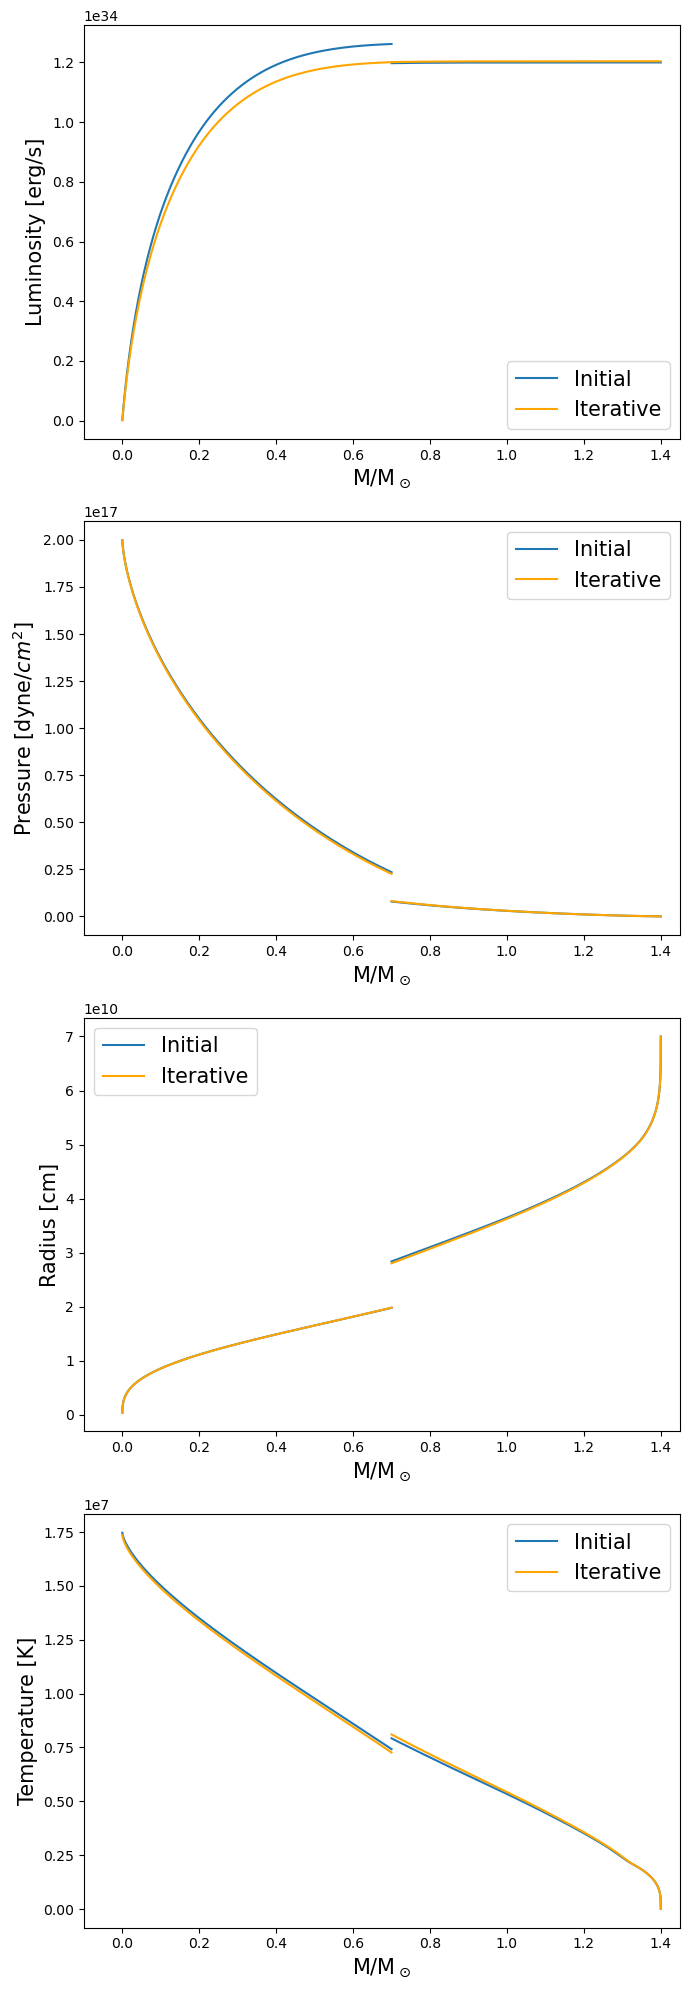

In [25]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))
axs[0].plot(sol1.t/Ms, sol1.y[0, :], color='#1f77b4', label = 'Initial')
axs[0].plot(sol2.t/Ms, sol2.y[0, :], color='#1f77b4')
axs[0].plot(sol1_it.t/Ms, sol1_it.y[0, :], color='orange', label = 'Iterative')
axs[0].plot(sol2_it.t/Ms, sol2_it.y[0, :], color='orange')
axs[0].set_xlabel('M/M$_\odot$', fontsize=15)
axs[0].set_ylabel('Luminosity [erg/s]', fontsize=15)
axs[0].set_xlim(-0.1, 1.45)
axs[0].legend(fontsize=15)


axs[1].plot(sol1.t/Ms, sol1.y[1, :], color='#1f77b4', label = 'Initial')
axs[1].plot(sol2.t/Ms, sol2.y[1, :], color='#1f77b4')
axs[1].plot(sol1_it.t/Ms, sol1_it.y[1, :], color='orange', label = 'Iterative')
axs[1].plot(sol2_it.t/Ms, sol2_it.y[1, :], color='orange')
axs[1].set_xlabel('M/M$_\odot$', fontsize=15)
axs[1].set_ylabel('Pressure [dyne/$cm^{2}$]', fontsize=15)
axs[1].set_xlim(-0.1, 1.45)
axs[1].legend(fontsize=15)

axs[2].plot(sol1.t/Ms, sol1.y[2, :], color='#1f77b4', label = 'Initial')
axs[2].plot(sol2.t/Ms, sol2.y[2, :], color='#1f77b4')
axs[2].plot(sol1_it.t/Ms, sol1_it.y[2, :], color='orange', label = 'Iterative')
axs[2].plot(sol2_it.t/Ms, sol2_it.y[2, :], color='orange')
axs[2].set_xlabel('M/M$_\odot$', fontsize=15)
axs[2].set_ylabel('Radius [cm]', fontsize=15)
axs[2].set_xlim(-0.1, 1.45)
axs[2].legend(fontsize=15)

axs[3].plot(sol1.t/Ms, sol1.y[3, :], color='#1f77b4', label = 'Initial')
axs[3].plot(sol2.t/Ms, sol2.y[3, :], color='#1f77b4')
axs[3].plot(sol1_it.t/Ms, sol1_it.y[3, :], color='orange', label = 'Iterative')
axs[3].plot(sol2_it.t/Ms, sol2_it.y[3, :], color='orange')
axs[3].set_xlabel('M/M$_\odot$', fontsize=15)
axs[3].set_ylabel('Temperature [K]', fontsize=15)
axs[3].set_xlim(-0.1, 1.45)
axs[3].legend(fontsize=15)

plt.tight_layout()
plt.show()

### MESA

In [26]:
profile = MesaData('/Users/hayleynofi/Desktop/Stellar/final/work/LOGS/profile100.data')
m = profile.mass     # in solar masses
P = profile.logP
R = profile.logR
T = profile.logT

In [27]:
mass_mesa = profile.mass # solar masses
pp = profile.pp
cno = profile.cno
eps = pp + cno  # erg/g/
mass_mesa = mass_mesa[::-1]
eps = eps[::-1]
# Compute dm (shell mass) in grams
dm = np.empty_like(mass_mesa)
dm[0] = mass_mesa[0]
dm[1:] = mass_mesa[1:] - mass_mesa[:-1]
dm *= Ms  # now in grams

# Integrate luminosity from center out
luminosity = np.cumsum(eps * dm)  # erg/s

# Total stellar luminosity:
L_total = luminosity[-1]
print(f"Total luminosity = {L_total:.3e} erg/s")
print(f"In solar units = {L_total / 3.828e33:.3f} Lsun")


Total luminosity = 1.519e+34 erg/s
In solar units = 3.969 Lsun


In [2]:
### MESA

profile = MesaData('/Users/hayleynofi/Desktop/Stellar/AS.171.611-Final/work/LOGS/profile100.data')
m = profile.mass     # in solar masses
P = profile.logP
R = profile.logR
T = profile.logT

mass_mesa = profile.mass # solar masses
pp = profile.pp
cno = profile.cno
eps = pp + cno  # erg/g/
mass_mesa = mass_mesa[::-1]
eps = eps[::-1]
# Compute dm (shell mass) in grams
dm = np.empty_like(mass_mesa)
dm[0] = mass_mesa[0]
dm[1:] = mass_mesa[1:] - mass_mesa[:-1]
dm *= Ms  # now in grams

# Integrate luminosity from center out
luminosity = np.cumsum(eps * dm)  # erg/s

# Total stellar luminosity:
L_total = luminosity[-1]
print(f"Total luminosity = {L_total:.3e} erg/s")
print(f"In solar units = {L_total / 3.828e33:.3f} Lsun")


NameError: name 'Ms' is not defined

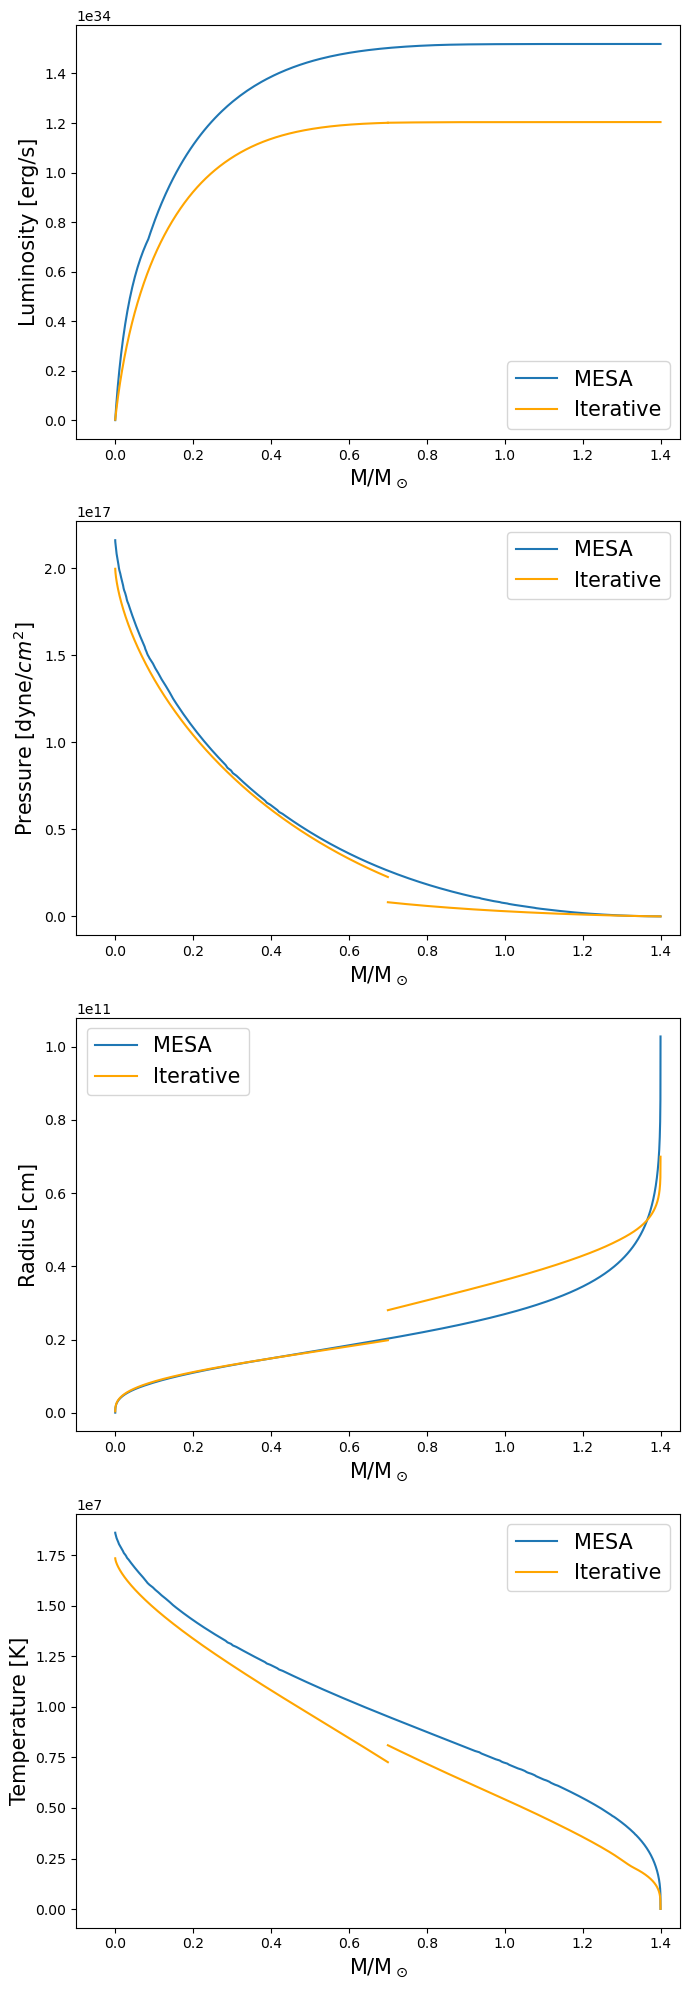

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))

axs[0].plot(mass_mesa, luminosity, label ='MESA')
axs[0].plot(sol1_it.t/Ms, sol1_it.y[0, :], color='orange', label = 'Iterative')
axs[0].plot(sol2_it.t/Ms, sol2_it.y[0, :], color='orange')
axs[0].set_xlabel('M/M$_\odot$', fontsize=15)
axs[0].set_ylabel('Luminosity [erg/s]', fontsize=15)
axs[0].set_xlim(-0.1, 1.45)
axs[0].legend(fontsize=15)


axs[1].plot(m, 10**P, label ='MESA')
axs[1].plot(sol1_it.t/Ms, sol1_it.y[1, :], color='orange', label = 'Iterative')
axs[1].plot(sol2_it.t/Ms, sol2_it.y[1, :], color='orange')
axs[1].set_xlabel('M/M$_\odot$', fontsize=15)
axs[1].set_ylabel('Pressure [dyne/$cm^{2}$]', fontsize=15)
axs[1].set_xlim(-0.1, 1.45)
axs[1].legend(fontsize=15)


axs[2].plot(m, (10**R)*Rs, label ='MESA')
axs[2].plot(sol1_it.t/Ms, sol1_it.y[2, :], color='orange', label = 'Iterative')
axs[2].plot(sol2_it.t/Ms, sol2_it.y[2, :], color='orange')
axs[2].set_xlabel('M/M$_\odot$', fontsize=15)
axs[2].set_ylabel('Radius [cm]', fontsize=15)
axs[2].set_xlim(-0.1, 1.45)
axs[2].legend(fontsize=15)

axs[3].plot(m, 10**T, label ='MESA')
axs[3].plot(sol1_it.t/Ms, sol1_it.y[3, :], color='orange', label = 'Iterative')
axs[3].plot(sol2_it.t/Ms, sol2_it.y[3, :], color='orange')
axs[3].set_xlabel('M/M$_\odot$', fontsize=15)
axs[3].set_ylabel('Temperature [K]', fontsize=15)
axs[3].set_xlim(-0.1, 1.45)
axs[3].legend(fontsize=15)

plt.tight_layout()
plt.show()

In [30]:
best_fit

array([1.99869473e+17, 6.99512823e+10, 1.20389218e+34, 1.73841556e+07])

In [31]:
mesa_core = np.array([10**P[-1],(10**R[0])*Rs,luminosity[-1], 10**T[-1]])

((best_fit - mesa_core) / mesa_core)*100

array([ -7.50525234, -31.93438323, -20.75597397,  -6.64948223])

### machine readable table

In [44]:
mass_df = np.concatenate((sol1.t, np.flip(sol2.t, axis=0)), axis=0)
data_df = np.concatenate((sol1.y, np.flip(sol2.y, axis=1)), axis=1).transpose()
df_result = pd.DataFrame(data = data_df, columns=['L', 'P', 'R', 'T'])
df_result['Mr'] = mass_df
df_result = df_result[['Mr', 'L', 'P', 'R', 'T']]

In [45]:
df_result['rho'] = density(X, Y, df_result['T'].to_numpy(),df_result['P'].to_numpy(), )
e_pp_df = energy_generation_pp(df_result['rho'].to_numpy(), df_result['T'].to_numpy(), X)
e_cno_df = energy_generation_CNO(df_result['rho'].to_numpy(), df_result['T'].to_numpy(), X, Z)
df_result['epsilon'] = e_pp_df + e_cno_df
df_result['kappa'] = opacity(lines, df_result['R'].to_numpy(), df_result['T'].to_numpy())

del_rad_df = del_rad(df_result['Mr'].to_numpy(),df_result['L'].to_numpy(), df_result['P'].to_numpy(), df_result['T'].to_numpy(), X, Y, lines)
df_result['del_ad'] = del_ad(df_result['P'].to_numpy(), df_result['T'].to_numpy())
df_result['del_nabla'] = del_nabla(df_result['Mr'].to_numpy(), df_result['L'].to_numpy(),df_result['P'].to_numpy(), df_result['T'].to_numpy(), X, Y,lines)
df_result['Shell'] = ['Rad' if del_rad_df[i] < df_result['del_ad'][i] else 'Ad' for i in range(len(df_result['del_nabla']))]

In [48]:
df_result

,Mr,L,P,R,T,rho,epsilon,kappa,del_ad,del_nabla,Shell
0,2.784600e+28,1.934203e+31,1.998146e+17,4.271933e+08,1.746939e+07,8.534174e+01,8.363607e+01,9.977001e+09,0.398601,0.398601,Ad
1,1.670871e+29,3.091501e+31,1.993898e+17,7.757620e+08,1.745452e+07,8.523296e+01,8.268637e+01,9.977001e+09,0.398602,0.398602,Ad
2,3.063283e+29,4.238002e+31,1.990850e+17,9.499120e+08,1.744385e+07,8.515485e+01,8.201231e+01,9.977001e+09,0.398604,0.378039,Rad
3,4.455694e+29,5.375909e+31,1.988275e+17,1.076054e+09,1.743482e+07,8.508881e+01,8.144744e+01,9.977001e+09,0.398605,0.329941,Rad
4,5.848106e+29,6.506409e+31,1.985919e+17,1.178896e+09,1.742655e+07,8.502839e+01,8.093466e+01,9.977001e+09,0.398606,0.304463,Rad
...,...,...,...,...,...,...,...,...,...,...,...
19995,2.784043e+33,1.200000e+34,4.410177e+11,6.468750e+10,4.159392e+05,7.919071e-03,4.071524e-16,2.063199e+134,0.399795,0.080711,Rad
19996,2.784182e+33,1.200000e+34,3.247511e+11,6.505950e+10,3.853428e+05,6.294358e-03,1.058478e-16,2.259024e+133,0.399795,0.080675,Rad
19997,2.784322e+33,1.200000e+34,2.114382e+11,6.554076e+10,3.461744e+05,4.561803e-03,1.519943e-17,9.504497e+131,0.399795,0.080642,Rad
19998,2.784461e+33,1.200000e+34,1.020760e+11,6.626198e+10,2.886042e+05,2.641612e-03,4.897991e-19,9.305936e+128,0.399795,0.080584,Rad


In [47]:
df_result.to_csv('stellarmodel_nofi.csv', index=False)